In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import pyodbc
import json

# Past Delta Analysis

This notebook will look at trends in past scrapes, in order to create a better predictive model to find what pages to scrape.

In [5]:
# Setup SQL
global con, cur
with open(r"../sql-config.json") as f:
    sql_config = json.load(f)
con = pyodbc.connect(
    "Driver={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.0.so.1.1};"
    "TrustServerCertificate=yes;"
    f"Server={sql_config['ip']},{sql_config['port']};"
    f"Database={sql_config['database']};"
    f"UID={sql_config['uid']};"
    f"PWD={sql_config['password']};"
)
cur = con.cursor()

In [6]:
# Pull all data from FatTrimmerData into df
df = pd.DataFrame()
sql = "SELECT * FROM FatTrimmerData;"
for chunk in pd.read_sql(sql, con, chunksize=10000):
    df = pd.concat([df, chunk])

/home/andy/.local/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [26]:
# Remove outliers
df = df[(np.abs(stats.zscore(df["DeltaTime"])) < 3)]

In [27]:
df.head()

,NewItems,PageNumber,DeltaTime,Batch
0,False,580,2370000,145480
1,False,580,4489000,145602
2,False,580,5688000,145748
3,False,580,5103000,145874
4,False,580,7057000,146074


In [28]:
df.describe()

,PageNumber,DeltaTime,Batch
count,543272.000000,5.432720e+05,543272.000000
mean,896.802902,7.178591e+06,116092.494758
std,518.037586,5.987653e+06,43045.915386
min,0.000000,-9.000000e+03,1717.000000
25%,448.000000,3.418000e+06,93863.750000
50%,897.000000,4.828000e+06,128128.000000
75%,1345.000000,8.597000e+06,148202.000000
max,1816.000000,3.081700e+07,172495.000000


<AxesSubplot:xlabel='NewItems', ylabel='DeltaTime'>

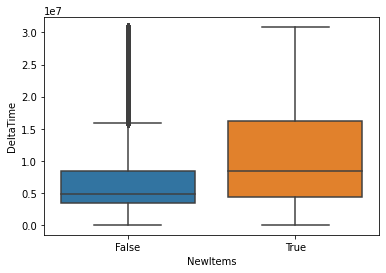

In [29]:
# Corelation between time between scrapes, and if that page had new items
sns.boxplot(
    x=df["NewItems"],
    y=df["DeltaTime"]
)

<AxesSubplot:xlabel='PageNumber', ylabel='DeltaTime'>

/usr/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


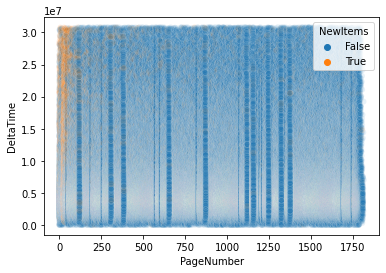

In [30]:
# scrape time vs. how common that page was
sns.scatterplot(
    x=df["PageNumber"],
    y=df["DeltaTime"],
    hue=df["NewItems"],
    alpha=0.1,
)
# sns.regplot(
#     x=df["PageNumber"],
#     y=df["DeltaTime"]
# )

[Text(0.5, 1.0, 'Page number vs time in between scrapes for pages with new items')]

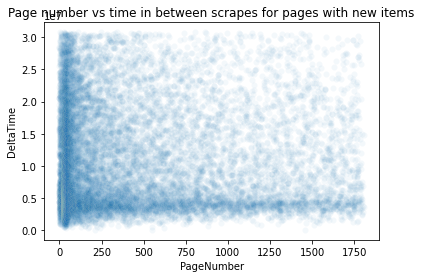

In [31]:
# scrape time vs. how common that page was, new items only
new_only = df[df.NewItems == True]
sns.scatterplot(
    x=new_only["PageNumber"],
    y=new_only["DeltaTime"],
    alpha=0.05,
).set(title="Page number vs time in between scrapes for pages with new items")